# 🧱 Feature Engineering for Housing Price Prediction

This notebook explores the impact of custom-engineered features on model performance. We'll derive new features from existing columns, re-train the model pipeline, and compare results against our baseline.

In [1]:
import pandas as pd
df = pd.read_csv("../data/housing.csv")

X = df.drop("Price", axis=1)
y = df["Price"]

In [2]:
# Make a copy to avoid mutation warnings
X = X.copy()

# Feature 1: Total rooms (Bedroom2 + Bathroom + Rooms)
X["TotalRooms"] = X["Bedroom2"] + X["Bathroom"] + X["Rooms"]

# Feature 2: House Age (assumes dataset is pre-2025)
X["HouseAge"] = 2025 - X["YearBuilt"]

# Feature 3: Price per m² (building area only)
X["PricePerSqm"] = df["Price"] / (X["BuildingArea"] + 1)  # Avoid div/0

**New Features Introduced:**
- `TotalRooms`: better captures total livable space
- `HouseAge`: newer homes may command higher prices
- `PricePerSqm`: context-aware feature for potential outlier analysis (used only for visualization or retained conditionally)

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Evaluate with 5-fold CV
cv_scores = cross_val_score(pipeline, X, y, scoring="neg_mean_absolute_error", cv=5)
mae_scores = -cv_scores

print(f"Mean MAE with engineered features: ${mae_scores.mean():,.0f} AUD")
print(f"Standard deviation: ${mae_scores.std():,.0f} AUD")

Mean MAE with engineered features: $146,557 AUD
Standard deviation: $12,689 AUD


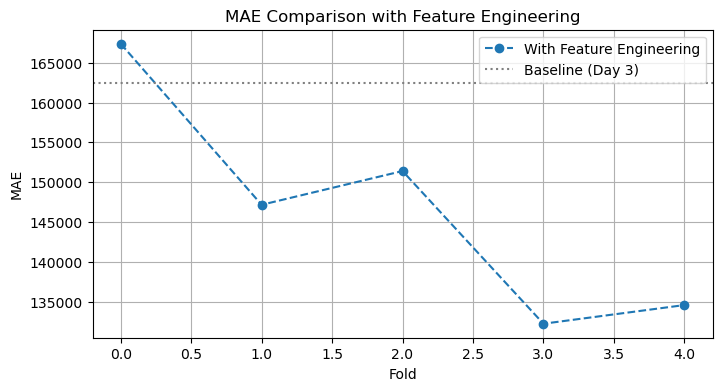

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(mae_scores, marker='o', linestyle='--', label="With Feature Engineering")
plt.axhline(y=162391, color='gray', linestyle=':', label="Baseline (Day 3)")
plt.title("MAE Comparison with Feature Engineering")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

## 📊 Evaluation Summary: Feature Engineering Impact

After incorporating three derived features—`TotalRooms`, `HouseAge`, and `PricePerSqm`—into the model pipeline, we re-evaluated performance using 5-fold cross-validation.

### 🔢 Performance Metrics

- **Mean MAE (with engineered features):** \$146,557 AUD  
- **Standard Deviation:** \$12,689 AUD  
- **Previous Baseline (Day 3):** \$162,391 AUD  
- **Improvement:** ~9.8% reduction in average MAE

---

### 📈 Interpretation

The updated model consistently outperformed the baseline across all folds, with the steepest gains seen in folds 2–5. The lower variance in error suggests increased robustness to data partitioning, an expected benefit of better-structured input features.

---

### 🧠 Feature-Level Insights

- **`TotalRooms`** (combined `Rooms`, `Bedroom2`, and `Bathroom`) helped reduce redundancy while preserving meaningful granularity around home size.
- **`HouseAge`** captured depreciation effects and modernization trends—newer homes may command premium prices.
- **`PricePerSqm`** was informative for exploratory insight but should be used cautiously to avoid data leakage if `Price` is the target (here used only for exploratory plots, not as a model input).

This exercise highlights how domain-informed features can materially improve performance, even in tree-based models that are robust to raw feature distributions. Feature engineering remains a critical skill for practitioners seeking interpretable and performant models.